# Chapter 2.1 - Data Preprocessing

## Step 1: Load Profile Data (Features)

In the following code section, the raw load profile data used in this work is imported, cleaned, reduced and transformed 
into cleanly structured time series for further processing.

#### Data Cleaning, Reduction and Transformation

In [32]:
# Import required Python modules
import pandas as pd
from pandas import Series, DataFrame, MultiIndex
import numpy as np
from datetime import datetime
from datetime import timedelta 
import timeit
import csv
from matplotlib import pyplot as plt
import random
import time

start_time = time.time()

# Case 1: import an existing sample of household-ids
# sample_ids = pd.read_pickle('Sample_IDs_n=5000.pkl')['IDs'].tolist()
sample_ids = pd.read_pickle('Simulation_IDs.pkl').to_numpy(dtype='float64')
n = len(sample_ids)

# Case 2: create, save and continue with a new household-ID-sample
# n = 15000
# sample_ids = random.sample(pd.read_pickle('All_IDs.pkl')['IDs'].tolist(), n)
# pd.DataFrame(data=sample_ids, columns=['IDs']).to_pickle('Sample_IDs_n={}.pkl'.format(n))

# Create an empty list to store the transformed load profiles of all months and concat them after the list is filled 
households_all_months = []

# Start the data transformation process for all months
for month in range(1,13):
    
    # Import the full raw household data of the current month
    month_str = "0" + str(month) if (month<10) else str(month) 
    households_total = pd.read_pickle("ChicagoHouseholds\\{}_consumptionReformatted".format(month_str))

    # Construct a data sample including only the households with the pre-determined sample-IDs
    households_sample = households_total[households_total['accountIdentifier'].isin(sample_ids)].copy()

    # Temporarily replace the '2400'-time-values with '2359' to enable the creation of preliminary datetime-objects
    households_sample.time.replace('hr2400', 'hr2359', inplace=True)

    # Before the date-values are transformed, save the value of the month's first day in the old format (170XX),
    # so that it can be used to calculate the current day from the old format later
    old_value = int(households_sample[:1]['date']) - 1

    # Join the date- and time-values to get a unique 'date+time'-value for each time step, to enable the creation of a pivot-table 
    households_sample['date'] = households_sample['date'].astype(str) + households_sample['time'].astype(str)

    # Create a pivot table to generate a clean, redundancy-free time series and reduce storage consumption
    # rows = time steps, columns = household-IDs, entries = consumption for each household-ID at each time step
    households = households_sample.pivot(index='date', columns='accountIdentifier', values='hh_consumption')
    
    # Drop redundant time values ('24:30' and '25:00') from the pivot table
    redundant_values = [index for index in households.index.array if ('2430' in index) | ('2500' in index)]
    households.drop(redundant_values, inplace=True)

    # Transform the 'date+time'-values into functional datetime-objects
    households.index = households.index.map(lambda date : datetime.strptime(str(int(date[:5])-old_value) + '-{}-2016-'.format(month) + date[9:11] + '-' + date[11:13], '%d-%m-%Y-%H-%M'))

    # Correct the '24:00h-problem': replace all '24:00h'-values of day x with '00:00h'-values of day x+1
    index_cleaned = []
    for dt in households.index:
            if(dt.minute==59):
                dt = dt + timedelta(days=1)
                dt = dt.replace(hour=0, minute=0)
            index_cleaned.append(dt)
    households.index = index_cleaned
    
    # Sort the data by columns-label so that the columns are in identical order for concatenation
    # Using Mergesort, since it is the only stable sorting algorithm
    households.sort_index(axis='columns', inplace=True, kind='mergesort')
    
    # Add the cleaned data for the current month to the list containing the transformed load profiles of all months
    households_all_months.append(households)

    print("Month Nr. {} finished".format(month))

# After completing the data transformation of all months, concatenate the list of DataFrames to create a single DataFrame containing the data for the whole year
households_2016 = pd.concat(households_all_months, axis='rows')

# Create a Multi-Index with day and time to simplify grouping by day during the parameter calculation in chapter 3.2.
date_indexes = []
time_indexes = []
for i in households_2016.index:
    date_indexes.append(datetime.strptime('{}-{}-{}'.format(i.year, i.month, i.day),'%Y-%m-%d'))
    time_indexes.append(i)
households_2016.index = pd.MultiIndex.from_arrays([date_indexes, time_indexes], names=['Day', 'Time'])

# Rename the column-axis
households_2016.columns.rename(name='Household-IDs', inplace=True)

# Save the final data
households_2016.to_pickle('Data/households_cleaned_2016_simulation.pkl')

print("All months finished")
print('Calculation Runtime: {:.2} Minutes'.format((time.time() - start_time)/60))

Month Nr. 1 finished
Month Nr. 2 finished
Month Nr. 3 finished
Month Nr. 4 finished
Month Nr. 5 finished
Month Nr. 6 finished
Month Nr. 7 finished
Month Nr. 8 finished
Month Nr. 9 finished
Month Nr. 10 finished
Month Nr. 11 finished
Month Nr. 12 finished
All months finished
Calculation Runtime: 1.5e+01 Minutes


In [32]:
# Inspect the finalized time series
pd.read_pickle('Data/households_cleaned_2016_simulation.pkl')

Household-IDs                   100061616572321  1000623286326231  \
Day        Time                                                     
2016-01-01 2016-01-01 00:30:00           0.0225            0.3475   
           2016-01-01 01:00:00           0.0675            0.3500   
           2016-01-01 01:30:00           0.0225            0.3325   
           2016-01-01 02:00:00           0.0575            0.3375   
           2016-01-01 02:30:00           0.0575            0.3750   
...                                         ...               ...   
2016-12-31 2016-12-31 22:00:00           0.2325            0.3875   
           2016-12-31 22:30:00           0.1775            0.3975   
           2016-12-31 23:00:00           0.1000            0.4800   
           2016-12-31 23:30:00           0.1800            0.4850   
2017-01-01 2017-01-01 00:00:00           0.7025            0.5150   

Household-IDs                   1000626063831495  1000634849535454  \
Day        Time                                                      
2016-01-01 2016-01-01 00:30:00            0.2700            0.1083   
           2016-01-01 01:00:00            0.2400            0.1724   
           2016-01-01 01:30:00            0.2175            0.1032   
           2016-01-01 02:00:00            0.1850            0.1033   
           2016-01-01 02:30:00            0.1650            0.1578   
...                                          ...               ...   
2016-12-31 2016-12-31 22:00:00            0.3050            0.7296   
           2016-12-31 22:30:00            0.2150            0.6868   
           2016-12-31 23:00:00            0.2850            0.2848   
           2016-12-31 23:30:00            0.1850            0.1898   
2017-01-01 2017-01-01 00:00:00            0.1925            0.1383   

Household-IDs                   1000643682431604  10005970974290684  \
Day        Time                                                       
2016-01-01 2016-01-01 00:30:00            0.3350             0.2850   
           2016-01-01 01:00:00            0.2900             0.3400   
           2016-01-01 01:30:00            0.1875             0.3525   
           2016-01-01 02:00:00            0.1550             0.3325   
           2016-01-01 02:30:00            0.1425             0.3275   
...                                          ...                ...   
2016-12-31 2016-12-31 22:00:00            0.1775             0.3175   
           2016-12-31 22:30:00            0.1325             0.3600   
           2016-12-31 23:00:00            0.1700             0.3150   
           2016-12-31 23:30:00            0.1950             0.3400   
2017-01-01 2017-01-01 00:00:00            0.3125             0.3100   

Household-IDs                   10005985465838684  10006012732591514  \
Day        Time                                                        
2016-01-01 2016-01-01 00:30:00             0.0950             0.4550   
           2016-01-01 01:00:00             0.0950             0.4525   
           2016-01-01 01:30:00             0.0950             0.4975   
           2016-01-01 02:00:00             0.0925             0.5000   
           2016-01-01 02:30:00             0.0950             0.5375   
...                                           ...                ...   
2016-12-31 2016-12-31 22:00:00             0.1450             0.0675   
           2016-12-31 22:30:00             0.1475             0.1000   
           2016-12-31 23:00:00             0.1475             0.0675   
           2016-12-31 23:30:00             0.1450             0.0675   
2017-01-01 2017-01-01 00:00:00             0.1475             0.0675   

Household-IDs                   10006013492777270  10006033110939880  ...  \
Day        Time                                                       ...   
2016-01-01 2016-01-01 00:30:00             0.2275             0.4875  ...   
           2016-01-01 01:00:00             0.2000             0.4925  ...   
           2016-01-01 

#### Data Normalization

In [34]:
# Import the transformed time series generated in the last step
households = pd.read_pickle('Data/households_cleaned_2016_simulation.pkl')

# Compute the yearly consumption of each household
households_sum = households.sum(axis='index')

# Normalize each time step of each household by the respective yearly consumption
households_normalized = (households / households_sum)

# Save and inspect the normalized time series
households_normalized.to_pickle('households_cleaned_2016_simulation_normalized.pkl')
households_normalized

Household-IDs                   100061616572321  1000623286326231  \
Day        Time                                                     
2016-01-01 2016-01-01 00:30:00         0.000004          0.000051   
           2016-01-01 01:00:00         0.000013          0.000051   
           2016-01-01 01:30:00         0.000004          0.000048   
           2016-01-01 02:00:00         0.000011          0.000049   
           2016-01-01 02:30:00         0.000011          0.000055   
...                                         ...               ...   
2016-12-31 2016-12-31 22:00:00         0.000046          0.000056   
           2016-12-31 22:30:00         0.000035          0.000058   
           2016-12-31 23:00:00         0.000020          0.000070   
           2016-12-31 23:30:00         0.000036          0.000071   
2017-01-01 2017-01-01 00:00:00         0.000140          0.000075   

Household-IDs                   1000626063831495  1000634849535454  \
Day        Time                                                      
2016-01-01 2016-01-01 00:30:00          0.000041          0.000024   
           2016-01-01 01:00:00          0.000036          0.000039   
           2016-01-01 01:30:00          0.000033          0.000023   
           2016-01-01 02:00:00          0.000028          0.000023   
           2016-01-01 02:30:00          0.000025          0.000036   
...                                          ...               ...   
2016-12-31 2016-12-31 22:00:00          0.000046          0.000165   
           2016-12-31 22:30:00          0.000033          0.000155   
           2016-12-31 23:00:00          0.000043          0.000064   
           2016-12-31 23:30:00          0.000028          0.000043   
2017-01-01 2017-01-01 00:00:00          0.000029          0.000031   

Household-IDs                   1000643682431604  10005970974290684  \
Day        Time                                                       
2016-01-01 2016-01-01 00:30:00          0.000060           0.000033   
           2016-01-01 01:00:00          0.000052           0.000039   
           2016-01-01 01:30:00          0.000034           0.000041   
           2016-01-01 02:00:00          0.000028           0.000039   
           2016-01-01 02:30:00          0.000026           0.000038   
...                                          ...                ...   
2016-12-31 2016-12-31 22:00:00          0.000032           0.000037   
           2016-12-31 22:30:00          0.000024           0.000042   
           2016-12-31 23:00:00          0.000031           0.000037   
           2016-12-31 23:30:00          0.000035           0.000039   
2017-01-01 2017-01-01 00:00:00          0.000056           0.000036   

Household-IDs                   10005985465838684  10006012732591514  \
Day        Time                                                        
2016-01-01 2016-01-01 00:30:00           0.000058           0.000109   
           2016-01-01 01:00:00           0.000058           0.000109   
           2016-01-01 01:30:00           0.000058           0.000120   
           2016-01-01 02:00:00           0.000056           0.000120   
           2016-01-01 02:30:00           0.000058           0.000129   
...                                           ...                ...   
2016-12-31 2016-12-31 22:00:00           0.000088           0.000016   
           2016-12-31 22:30:00           0.000090           0.000024   
           2016-12-31 23:00:00           0.000090           0.000016   
           2016-12-31 23:30:00           0.000088           0.000016   
2017-01-01 2017-01-01 00:00:00           0.000090           0.000016   

Household-IDs                   10006013492777270  10006033110939880  ...  \
Day        Time                                                       ...   
2016-01-01 2016-01-01 00:30:00           0.000036           0.000038  ...   
           2016-01-01 01:00:00           0.000032           0.000038  ...   
           2016-01-01 

## Step 2: Simulation Data (Target)
In the following code section, the raw simulation data from the work of reference [1] is imported and transformed such that each communities' household IDs and the corresponding community profit and community gain are obtained.

#### Data cleaning and tranformation

In [44]:
# Import required Python modules
import pandas as pd
import numpy as np
import seaborn as sns

# Import and inspect the raw community simulation results from reference [0] and the communities' household IDs
simulation = pd.read_csv('Compare_Revenues_shared6.csv')
simulation.set_index('Unnamed: 0', inplace=True)
simulation.index.name = 'Communities'

communities = pd.read_csv('household.sample.csv')
communities.set_index('1', inplace=True)

simulation

,0BPro,1BPro,2Pro,3Con,4Con,singleProfit,communityProfit,communityGain
Communities,,,,,,,,
0,221.944558,201.785974,-164.727320,-1200.0,-1200.0,3859.003211,4533.519606,674.516395
1,83.991734,211.944487,-54.787559,-1200.0,-1200.0,3841.148662,4732.097722,890.949060
2,268.017827,193.716673,-43.516460,-1200.0,-1200.0,4018.218040,4722.369129,704.151089
3,175.358831,161.695426,-140.052090,-1200.0,-1200.0,3797.002168,4464.871166,667.868998
4,61.914646,229.711800,-104.330639,-1200.0,-1200.0,3787.295807,4448.305418,661.009611
...,...,...,...,...,...,...,...,...
995,204.707395,212.260259,-88.548568,-1200.0,-1200.0,3928.419085,4490.263260,561.844174
996,149.216596,234.021223,-206.607851,-1200.0,-1200.0,3776.629969,4512.830113,736.200144
997,151.108223,190.892420,-208.726971,-1200.0,-1200.0,3733.273672,4354.621571,621.347899


In [45]:
communities

,[1000654542478946560,1000602809534211968,1000604635398125440,1000648946412869632,100060968938768448]
1,,,,,
2,[1000632859138991232,1000626348248254464,1000646467088847232,1000655480812552192,1000602177041726336]
3,[1000633102907786240,100059824522313856,1000620849719056128,1000626539311424896,1000607723861515136]
4,[100065152237226432,1000637347028321536,1000614201863622016,1000646206297653376,1000651251776032768]
5,[1000623338582402304,1000645561698445312,1000633913833561472,1000630503205892352,1000619946859569408]
6,[1000601726903831040,100059946378130544,1000651035015358592,100064918851833536,100063709383392624]
...,...,...,...,...,...
996,[1000598286637461504,1000619330625882752,1000626940057289728,1000647797952124800,100063560550534368]
997,[100061842331435952,1000622608289560832,1000651366547330048,1000631405025769984,1000633226808734080]
998,[1000612473978343040,1000596687444140288,1000645964849395712,1000604096203565952,1000631350932294784]


In [46]:
# Create a new DataFrame for the communities' household-IDs
data_columns = pd.DataFrame()
# Create one column for each pro- and consumer household type
column_values = ['Battery/PV_1', 'Battery/PV_2', 'PV', 'Consumer_1', 'Consumer_2']

# Iterate over all five household type columns
for i in range(0, len(column_values)):
    # Store the values of each columns in a temporary object
    temp = communities.iloc[:, i]
    # Workaround: one value per columns is apperently stored in the column name, add it to the temporary object
    temp = temp.append(pd.Series(data=temp.name, index=[999], name=str(i)))
    # Add the finalized column of household-IDs to the result DataFrame
    data_columns[column_values[i]] = temp
data_columns.index = range(0,1000)

# Merge each community's five household-IDs with the corresponding community profit and community gain 
simulation_results = pd.concat(objs=[data_columns, 
                                     simulation['communityGain'],
                                     simulation['communityProfit']], 
                               axis='columns')   
simulation_results.index = range(1,1001)

# Save the results
simulation_results.to_pickle('Data/Simulation_Results.pkl')

# Inspect the final results
simulation_results

,Battery/PV_1,Battery/PV_2,PV,Consumer_1,Consumer_2,communityGain,communityProfit
1,[1000632859138991232,1000626348248254464,1000646467088847232,1000655480812552192,1000602177041726336],674.516395,4533.519606
2,[1000633102907786240,100059824522313856,1000620849719056128,1000626539311424896,1000607723861515136],890.949060,4732.097722
3,[100065152237226432,1000637347028321536,1000614201863622016,1000646206297653376,1000651251776032768],704.151089,4722.369129
4,[1000623338582402304,1000645561698445312,1000633913833561472,1000630503205892352,1000619946859569408],667.868998,4464.871166
5,[1000601726903831040,100059946378130544,1000651035015358592,100064918851833536,100063709383392624],661.009611,4448.305418
...,...,...,...,...,...,...,...
996,[100061842331435952,1000622608289560832,1000651366547330048,1000631405025769984,1000633226808734080],561.844174,4490.263260
997,[1000612473978343040,1000596687444140288,1000645964849395712,1000604096203565952,1000631350932294784],736.200144,4512.830113
998,[1000634333074172544,1000630955884579968,1000620958696774016,1000634298268062720,1000651502694812416],621.347899,4354.621571
999,[1000612700316547328,1000636820482854528,1000637296728815104,1000615611614925440,1000612578554648064],633.812715,4421.577346


#### Data discretization

In [47]:
import pandas as pd
import numpy as np

# Import the transformed simulation data from the last step
simulation_results = pd.read_pickle('Data/Simulation_Results.pkl')

# Discretize the target variables Community Profit and Community Gain into three balanced classes using the respective terciles
simulation_results['CommunityProfit_Class'] = pd.qcut(x=simulation_results['communityProfit'], q=3, labels=['Low', 'Medium', 'High'])
simulation_results['CommunityGain_Class'] = pd.qcut(x=simulation_results['communityGain'], q=3, labels=['Low', 'Medium', 'High'])
simulation_results.rename(columns={'communityProfit':'CommunityProfit', 'communityGain':'CommunityGain'}, inplace=True)

# Save and inspect the new values
simulation_results.to_pickle('Data/Simulation_Results.pkl')
simulation_results

,Battery/PV_1,Battery/PV_2,PV,Consumer_1,Consumer_2,CommunityGain,CommunityProfit,CommunityProfit_Class,CommunityGain_Class
1,[1000632859138991232,1000626348248254464,1000646467088847232,1000655480812552192,1000602177041726336],674.516395,4533.519606,Medium,Medium
2,[1000633102907786240,100059824522313856,1000620849719056128,1000626539311424896,1000607723861515136],890.949060,4732.097722,High,High
3,[100065152237226432,1000637347028321536,1000614201863622016,1000646206297653376,1000651251776032768],704.151089,4722.369129,High,Medium
4,[1000623338582402304,1000645561698445312,1000633913833561472,1000630503205892352,1000619946859569408],667.868998,4464.871166,Low,Medium
5,[1000601726903831040,100059946378130544,1000651035015358592,100064918851833536,100063709383392624],661.009611,4448.305418,Low,Low
...,...,...,...,...,...,...,...,...,...
996,[100061842331435952,1000622608289560832,1000651366547330048,1000631405025769984,1000633226808734080],561.844174,4490.263260,Medium,Low
997,[1000612473978343040,1000596687444140288,1000645964849395712,1000604096203565952,1000631350932294784],736.200144,4512.830113,Medium,High
998,[1000634333074172544,1000630955884579968,1000620958696774016,1000634298268062720,1000651502694812416],621.347899,4354.621571,Low,Low
999,[1000612700316547328,1000636820482854528,1000637296728815104,1000615611614925440,1000612578554648064],633.812715,4421.577346,Low,Low


#### Simulation Data Visualization

<Figure size 6000x4000 with 0 Axes>

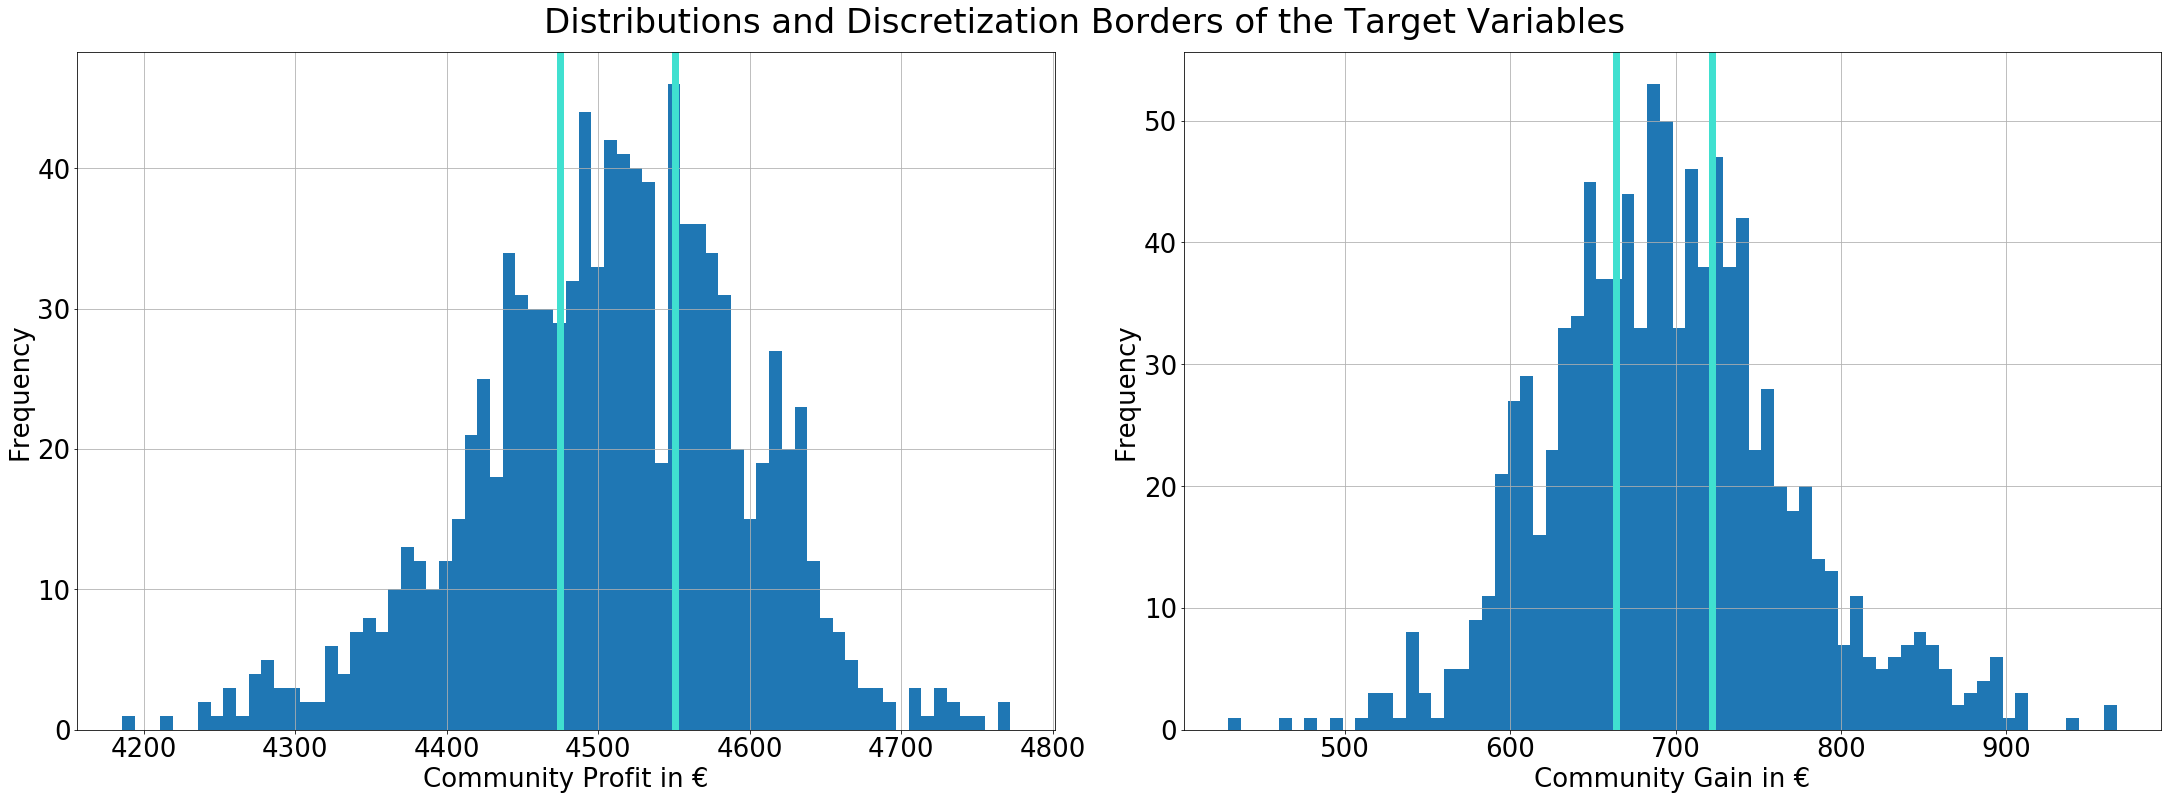

In [48]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

# Import the simulation data
simulation = pd.read_pickle('Data/Simulation_Results.pkl')
community_profit = simulation['CommunityProfit']
community_gain = simulation['CommunityGain']

# Configure general plotting settings and create a figure 
SMALL = 22
MEDIUM = 26
LARGE = 30
XLARGE = 34
plt.rc('font', size=MEDIUM) 
plt.rc('axes', labelsize=MEDIUM)    
plt.rc('xtick', labelsize=MEDIUM)   
plt.rc('ytick', labelsize=MEDIUM)   
plt.rc('legend', fontsize=LARGE)   
plt.rc('figure', titlesize=XLARGE)
plt.figure(dpi=1000)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,11), constrained_layout=True)
fig.suptitle('Distributions and Discretization Borders of the Target Variables')

# Plot the distribution including vertical lines for the terciles for the community profit 
community_profit.hist(bins=70, ax=ax1)
ax1.axvline(community_profit.quantile(q=(1/3)), color='turquoise', linewidth=7)
ax1.axvline(community_profit.quantile(q=(2/3)), color='turquoise', linewidth=7)
ax1.set_xlabel('Community Profit in €')
ax1.set_ylabel('Frequency')

# Plot the distribution including vertical lines for the terciles for the community gain 
community_gain.hist(bins=70, ax=ax2)
ax2.axvline(community_gain.quantile(q=(1/3)), color='turquoise', linewidth=7)
ax2.axvline(community_gain.quantile(q=(2/3)), color='turquoise', linewidth=7)
ax2.set_xlabel('Community Gain in €')
ax2.set_ylabel('Frequency')

plt.show()

In [49]:
# Since the plotting reveals that the distributions seem to be skewed, inspect the skewness values
print('Skewness Community Profit: ', community_profit.skew())
print('Skewness Community Gain: ', community_gain.skew())

Skewness Community Profit:  -0.3108480054633112
Skewness Community Gain:  0.3294462205865386


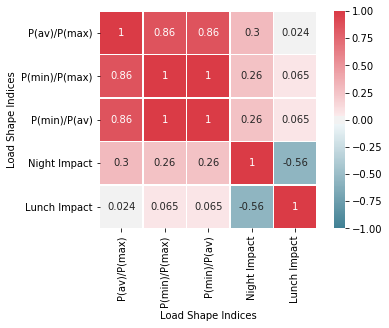

In [10]:
# # sns.pairplot(load_shape_indices.T, kind='reg')
# sns.heatmap(load_shape_indices.T.corr(),
#             square=True,
#             linewidths=.5, 
#             vmin=-1.0,
#             vmax=1.0, 
#             cmap=sns.diverging_palette(220, 10, as_cmap=True), 
#             annot=True)